# LEARN_01_KAGGLE_Titanic_dataset 
#### The main task is to compare RandomForest, LogisticRegression and Neural Network on Titanic Dataset from KAGGLE website. Titanic dataset contains 12 columns with different passenger data. Passernger count is 891. One of the columns ("Survived") contains information whether a given passenger survived the sinking (value 1) or not (value 0). The task is to train models that will be able to estimate as accurately as possible whether a given passenger will survive the disaster based on the test data (maximum F1 Score for the group of survivors)

#### Import of necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score,  make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

#### Data import from csv file

In [2]:
titanic_dataset = pd.read_csv('Titanic-Dataset.csv')
titanic_dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### VARIABLE DESCRIPTIONS
#### Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
#### survival - Survival (0 = No; 1 = Yes)
#### name - Name
#### sex - Sex
#### age - Age
#### sibsp - Number of Siblings/Spouses Aboard
#### parch - Number of Parents/Children Aboard
#### ticket - Ticket Number
#### fare - Passenger Fare (British pound)
#### cabin - Cabin
#### embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

#### PassengerId, Ticket number columns have no relevant information for analysis. Can be dropped.

In [3]:
titanic_dataset.drop(['PassengerId'], axis=1, inplace=True)
titanic_dataset.drop(['Ticket'], axis=1, inplace=True)

#### Checking of null values in dataset. There are  missing approx 20% of age data, approx 77% of cabin number and approx. 0.2% of Embarked data

In [4]:
titanic_dataset.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

#### Checking for duplicates

In [5]:
titanic_dataset.duplicated().any()

False

#### Display basic descriptive statistics for numeric data

In [6]:
titanic_dataset.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Prepare copy of the dataset to be able to recover oryginal data without additional file access

In [7]:
titanic = titanic_dataset.copy()

#### Check of data balance for Survived column. Unbalance is moderate 62% - 38%

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


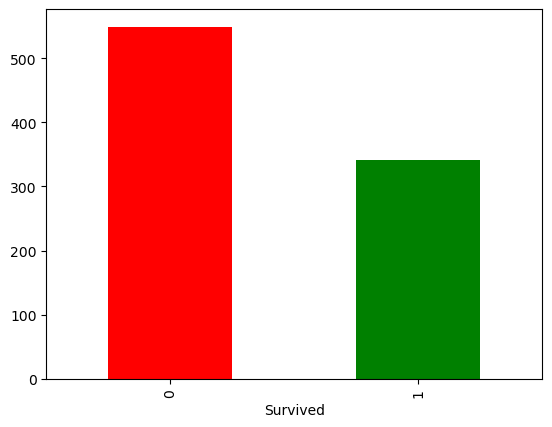

In [8]:
print(titanic['Survived'].value_counts(normalize=True))
CountSurv = pd.Series(titanic['Survived']).value_counts()
CountSurv.plot.bar(color=['red','green'])
plt.show()

#### Check the normalized value counts for all classes
#### The largest class is 3 (approx 55%), the other two have similar numbers

In [9]:
print(titanic['Pclass'].value_counts(normalize=True))

Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64


#### Check the differences in survival based on passenger class. 
#### There are significant  differences visible on below barplot between passenger classes regarding survival rate. 
#### On the chart there are also visible error bars. Error bars are graphical representations of data variability or uncertainty. They give a visual indication of the range of possible values or the confidence interval for each bar in a plot.

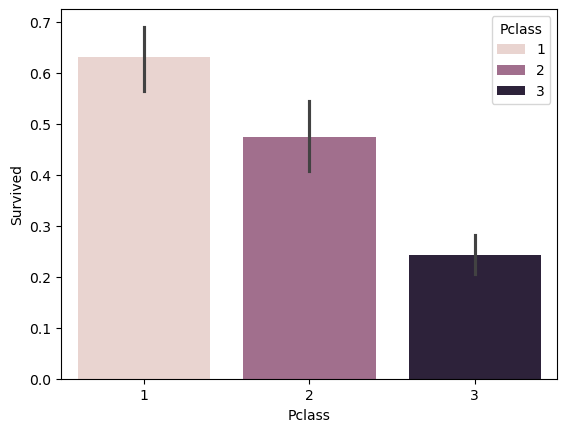

In [10]:
sns.barplot(x='Pclass', y='Survived', data=titanic, hue='Pclass')
plt.show()

#### It can be checked if title in Name column can be a factor in Survival probability. Extract title into the new column.

In [11]:
titanic['Title'] = titanic['Name'].str.split(', ', expand=True)[1].str.split('.',  expand=True)[0]
titanic.drop(['Name'], axis=1, inplace=True)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S,Rev
887,1,1,female,19.0,0,0,30.0000,B42,S,Miss
888,0,3,female,NaN,1,2,23.4500,NaN,S,Miss
889,1,1,male,26.0,0,0,30.0000,C148,C,Mr


#### Create plot with survival rate for each category in Title column

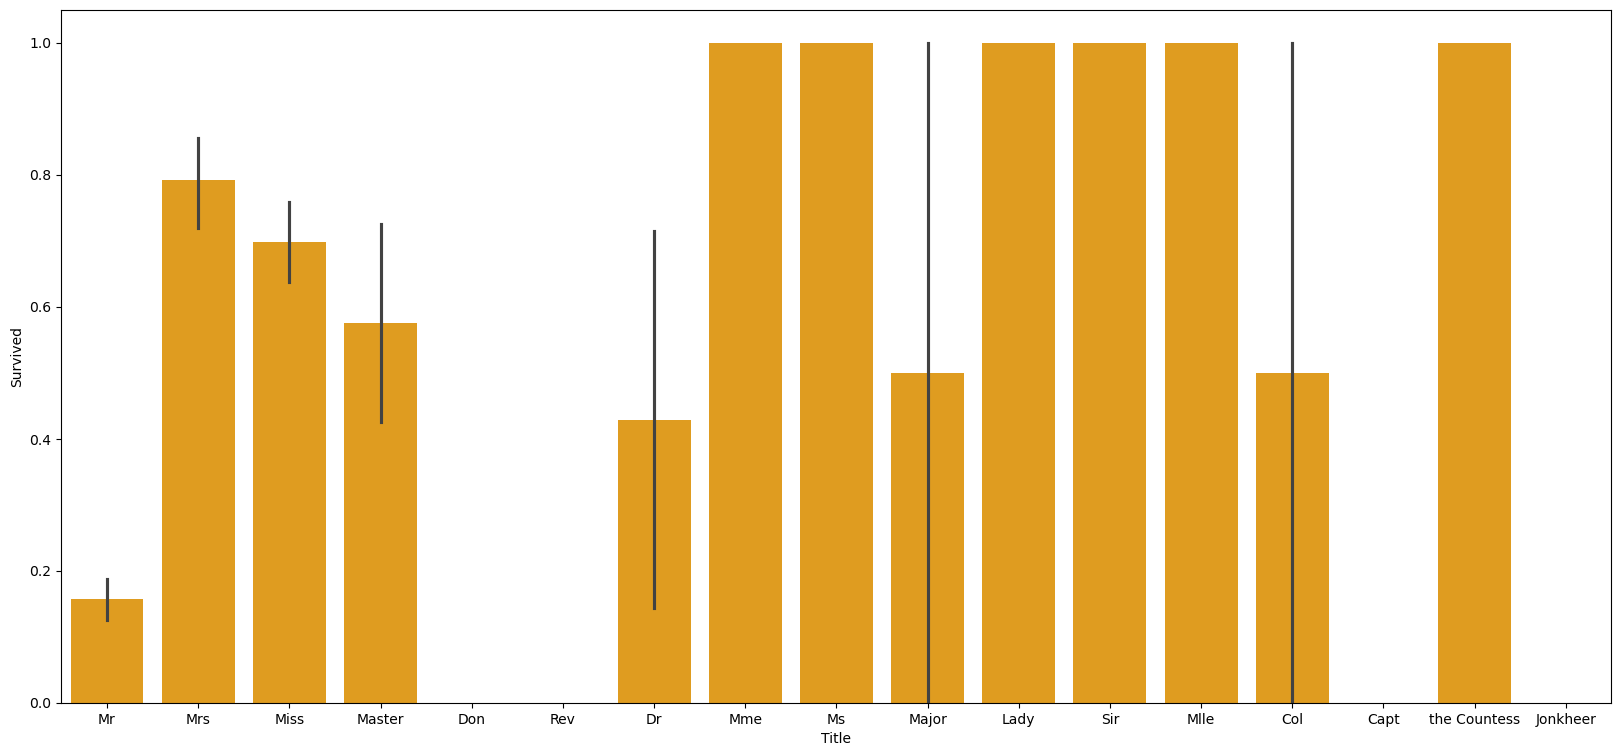

In [12]:
plt.figure(figsize=(20, 9))
sns.barplot(x='Title', y='Survived', data=titanic, color='orange')
plt.show()

#### Check the normalized value counts for all categories in the Title column. 
#### There are 3 most numerous categories. The rest can be combined into the 'Others' category

In [13]:
titanic['Title'].value_counts(normalize=True)

Title
Mr              0.580247
Miss            0.204265
Mrs             0.140292
Master          0.044893
Dr              0.007856
Rev             0.006734
Mlle            0.002245
Major           0.002245
Col             0.002245
the Countess    0.001122
Capt            0.001122
Ms              0.001122
Sir             0.001122
Lady            0.001122
Mme             0.001122
Don             0.001122
Jonkheer        0.001122
Name: proportion, dtype: float64

#### Check the number of women and men in dataset

Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64


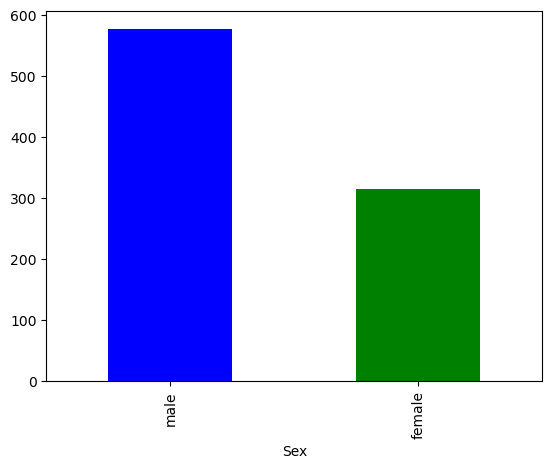

In [14]:
print(titanic['Sex'].value_counts(normalize=True))
CountSurv = pd.Series(titanic['Sex']).value_counts()
CountSurv.plot.bar(color=['blue','green'])
plt.show()

#### Check whether person's gender has an influence on survival rate. 
#### There is significant difference visible on below barplot.

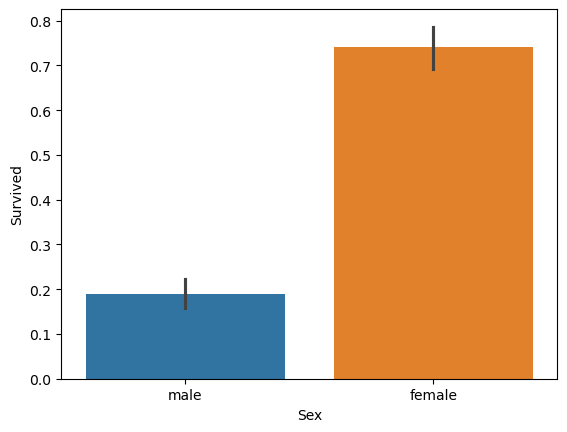

In [15]:
sns.barplot(x='Sex', y='Survived', data=titanic, hue='Sex')
plt.show()

#### Boxplot can be used to observe whether age affects survivallity 

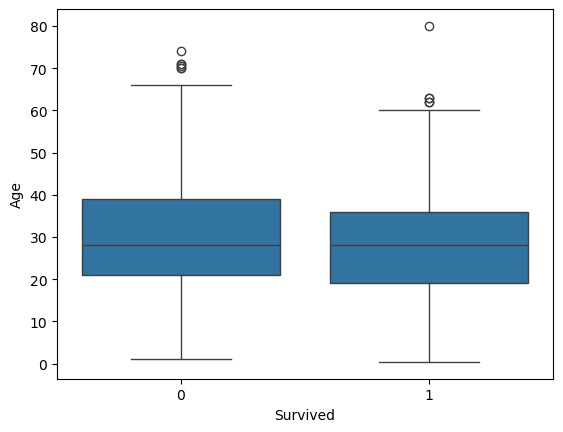

In [16]:
sns.boxplot(y='Age', x='Survived', data=titanic)
plt.show()

#### Structure of age of all passengers can be observed in histogram

<Axes: >

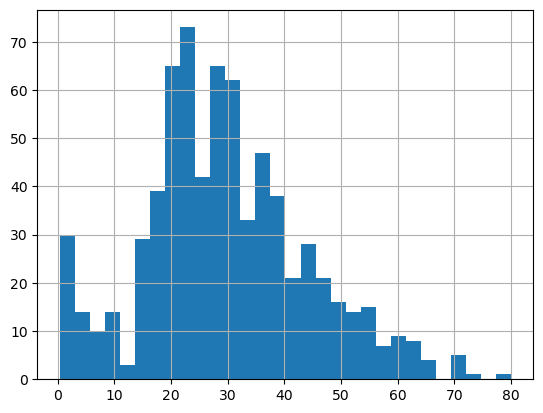

In [17]:
titanic['Age'].hist(bins=30)

#### On below histplot there are presented probability density based on age for people that survived or not.
#### Red line and green line cross few  times but it seems that age under 13 has better chances to survive and age beteen 13 and 31 less chancess. It is also visible that there is large number of childrens between age 10 - 8 that did not survive and it will affect probability density. 
#### Based on such histplot and above comments 3 groups can be proposed for better survivability recognition 0-8, 8-31, above 31

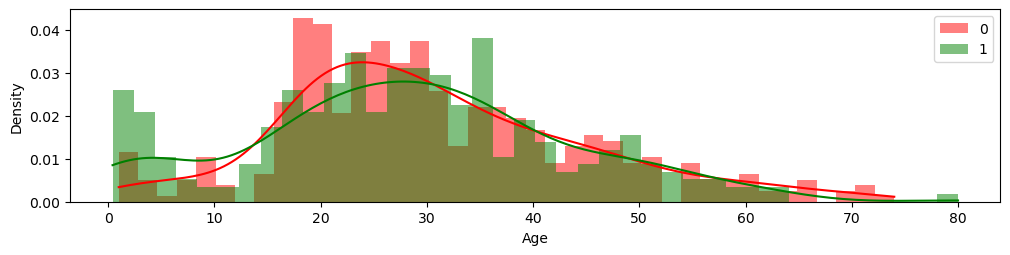

In [18]:
    plt.figure(figsize=(12, 2.5))
    sns.histplot(titanic.loc[titanic['Survived']==0, 'Age'], kde=True, stat="density", linewidth=0,color='red', label='0', bins=40)
    sns.histplot(titanic.loc[titanic['Survived']==1, 'Age'], kde=True, stat="density", linewidth=0, color='green', label='1', bins=40)
    plt.legend(loc='upper right')
    plt.show()

#### Data are devided for 3 groups according to above decision.
#### On below barplot it is visible that survival rate was much higher for children between 0-8 age then for two other groups. There is visible slighty higher survivability in group 31 and above.

In [19]:
titanic.loc[titanic['Age']<8 , 'AgeRange'] = 0
titanic.loc[(titanic['Age']>=8) & (titanic['Age']<31), 'AgeRange'] = 1
titanic.loc[titanic['Age']>=31 , 'AgeRange'] = 2

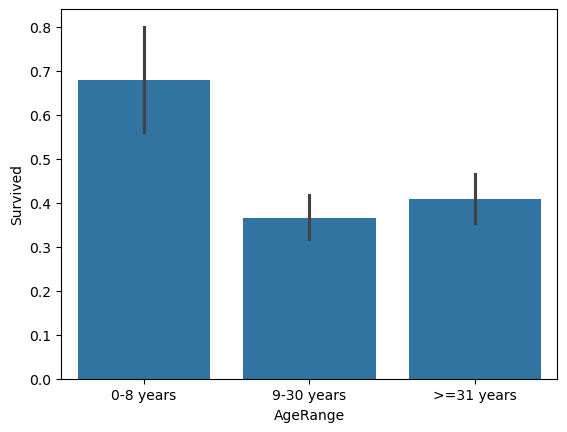

In [20]:
ax = sns.barplot(x='AgeRange', y='Survived', data=titanic)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['0-8 years', '9-30 years', '>=31 years'])
plt.show()

#### Much higher survivability is recognised for 7% of population

In [21]:
titanic['AgeRange'].value_counts(normalize=True)

AgeRange
1.0    0.505602
2.0    0.424370
0.0    0.070028
Name: proportion, dtype: float64

#### Check the normalized value counts for SibSp column (Number of Siblings/Spouses Aboard)

In [22]:
print(titanic['SibSp'].value_counts(normalize=True))

SibSp
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: proportion, dtype: float64


#### Check the differences in survival based on number of siblings/spouses aboard. 
#### There are significant  differences visible on below barplot depending on SibSp number. However for bigger number of siblings/spouses error bars are much larger. The reason is the uniqueness of such situations.

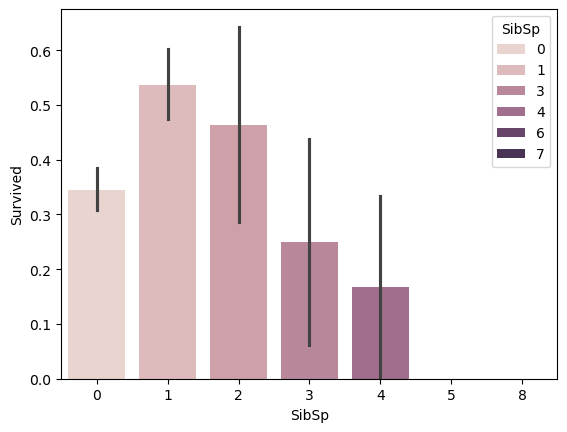

In [23]:
sns.barplot(x='SibSp', y='Survived', data=titanic, hue='SibSp')
plt.show()

#### Check the normalized value counts for Parch column (Number of Parents/Children Aboard)

In [24]:
print(titanic['Parch'].value_counts(normalize=True))

Parch
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: proportion, dtype: float64


#### Check the differences in survival based on number of of parents/children aboard. 
#### There are significant  differences visible on below barplot depending on Parch number. However for bigger number of parents/children error bars are much larger. The reason is the uniqueness of such situations.

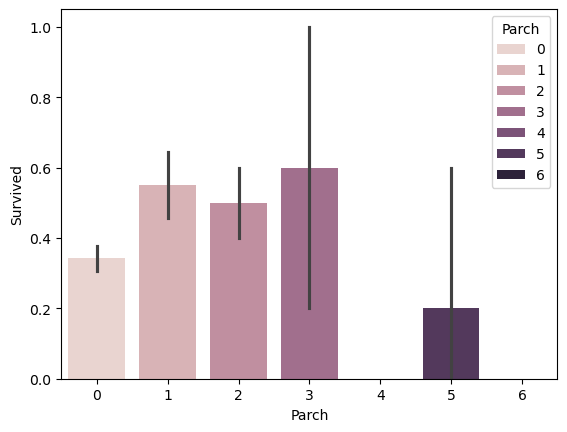

In [25]:
sns.barplot(x='Parch', y='Survived', data=titanic, hue='Parch')
plt.show()

#### Check the normalized value counts for Embarked column (Port of Embarkation: C = Cherbourg; Q = Queenstown; S = Southampton)

In [26]:
print(titanic['Embarked'].value_counts(normalize=True))

Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64


#### Check the differences in survival based on port of embarkation. Differences are visible

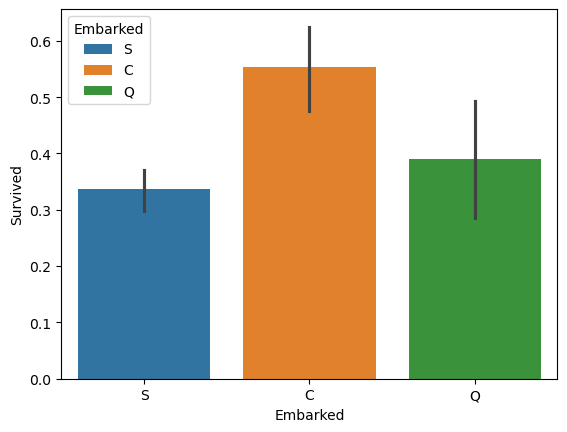

In [27]:
sns.barplot(x='Embarked', y='Survived', data=titanic, hue='Embarked')
plt.show()

#### Check if fare has impact on survivability. 
#### Below boxplot show that fare median of people that survived was higher. 

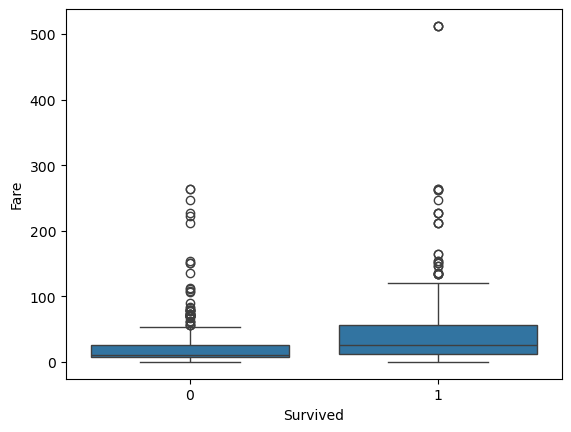

In [28]:
sns.boxplot(y='Fare', x='Survived', data=titanic)
plt.show()

#### Check if survival rate of passengers with defined cabin number was higher. 
#### Only approx 23% passengers have defined cabin number and below barplot show that survivability among them was much higher. 

In [29]:
titanic.loc[titanic['Cabin'].notna() , 'CabinNum'] = 1
titanic.loc[titanic['Cabin'].isna(), 'CabinNum'] = 0
titanic.drop(['Cabin'], axis=1, inplace=True)

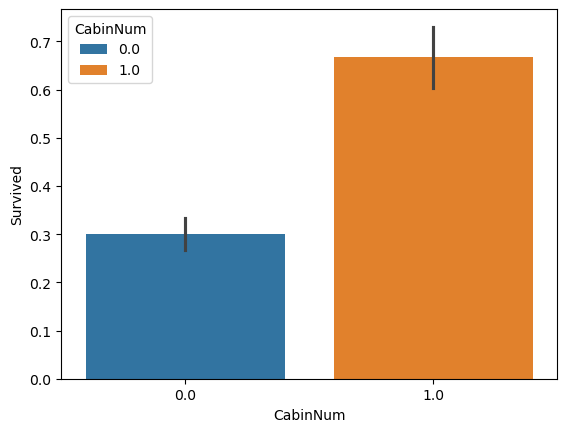

In [30]:
sns.barplot(x='CabinNum', y='Survived', data=titanic, hue='CabinNum')
plt.show()

#### Correlation check for variables
#### Below matrix show some inverse correlation beteen Fare and Pclass additionally between Age and Pclass. Correlation between SibSp and Parch is also visible.

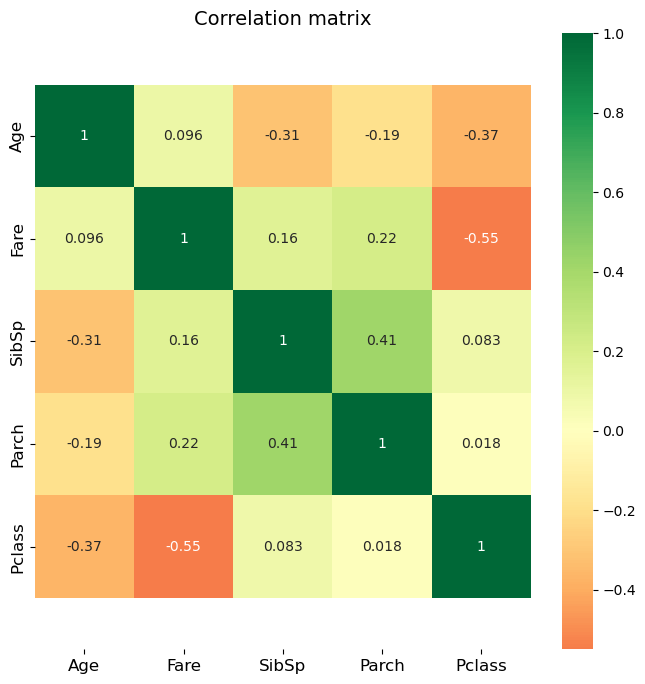

In [31]:
correlation_data=['Age','Fare','SibSp','Parch','Pclass']
plt.figure(figsize=(8, 8))
ax = sns.heatmap(titanic[correlation_data].corr(),
                 xticklabels=titanic[correlation_data].corr().columns,
                 yticklabels=titanic[correlation_data].columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Correlation matrix', fontsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Comparison of simple and advanced classifier (using grid search) and neural networks. 

#### The main task will be to maximize the F1 Score for passengers who survived the crash, so that the trained model can most accurately determine the group of passengers who will survive the crash. 

In [32]:
titanic = titanic_dataset.copy()

#### Data split for X and y. Ater that data set is separated into training and test data. Data stratification is necessary to ensure sufficient amount of minority class data for proper model training.

In [33]:
X = titanic.drop(['Survived'], axis=1).copy()
y = titanic['Survived'].copy()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#### defining which data we will treat as numeric and which as categorical. 'SibSp' and 'Parch' could also be treated as categorical data, but when using OneHotEncoder, quite a lot of variables would be created, so they are assigned to numeric variables

In [35]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Sex', 'Name', 'Cabin', 'Embarked', 'Pclass']

#### Class definition which will separate the prefixes Mr, Miss, Mrs from the Name column and create a separate category others

In [36]:
class Filter_Name(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), column] = 'Other'
        return X_transformed

#### Defining a class that allows to check which passengers had an assigned cabin number and which did not.

In [37]:
class Filter_Cabin(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed.loc[X_transformed[column].notna() , column] = 1
        X_transformed.loc[X_transformed[column].isna(), column] = 0
        return X_transformed

#### Creating a class that divides people into three age groups to better predict survival

In [38]:
class Age_Range(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed.loc[(X_transformed[column]<8), "AgeRange"] = 0
        X_transformed.loc[(X_transformed[column]>=8) & (X_transformed[column]<31), "AgeRange"] = 1
        X_transformed.loc[X_transformed[column]>=31, "AgeRange"] = 2
        return X_transformed

#### Defining a function that will save the results to a "DataFrame" and display a ConfusionMatrix

In [39]:
def result_summary(classifier_name, predict_test, metrics_df, y_test):
    report = classification_report(y_test, predict_test, output_dict=True)
    metrics_df.loc[metrics_df.shape[0]] = [classifier_name,'0',report['0']['precision'],report['0']['recall'],report['0']['f1-score']]
    metrics_df.loc[metrics_df.shape[0]] = [classifier_name,'1',report['1']['precision'],report['1']['recall'],report['1']['f1-score']]
    print(classification_report(y_test, predict_test))
    
    cm = confusion_matrix(y_test, predict_test)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    return metrics_df

#### Defining a function that finds the optimal threshold for neural networks that will allow obtaining the maximum F1 Score for class "1"

In [40]:
def max_treshold(y_pred_prob,  y_test):
    treshold = (np.arange(10, 90, 0.5)/100).tolist()
    max_tr = [0,0]
    for tresh in treshold:
        y_pred = (y_pred_prob > tresh).astype(int)
        report_cl = classification_report(y_test, y_pred, output_dict=True)
        f1 = report_cl['1']['f1-score']
        if f1 > max_tr[1]:
            max_tr = [tresh,f1]
    return max_tr[0]

#### dataframe metrics_df will be used to store summary data of tested classifiers. 

In [41]:
metrics_df = pd.DataFrame(columns = ['Classifier', 'Survived', 'Precision', 'Recall','F1-score'])

## LogisticRegression Classifier

#### The first classifier that will be used is LogisticRegression. In the first step, a Pipeline is prepared, the purpose of which is to prepare the data for classification, so that gridSeach can also be used. Numeric Data need to be scaled for LogisticRegression and for PCA. This is why StandardScaler() is used two times. All previously defined classes are used, missing data is filled in. OneHotEncoder is used on all categorical data. Data are not balanced so LogisticRegression will be run with class_weight='balanced' to cover this issue.

In [42]:
num_preparation = Pipeline(steps=[
    ('age_range', Age_Range(column='Age')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('scaler_1', StandardScaler()),
    ('pca', PCA()),
    ('scaler_2', StandardScaler())
                                 ])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('filter_cabin', Filter_Cabin(column='Cabin')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_LogReg = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(class_weight='balanced',  max_iter=20000))])

#### Params are defined for GridSearch, which finds the optimal parameters for the classifier with the highest F1 Score for class "1". The results are written to DataFrame, ClassificationReport, ConfusionMatrix are displayed

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Hyperparameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'sag', 'preprocessor__numeric_preprocessing__pca__n_components': 0.985}
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       110
           1       0.74      0.80      0.77        69

    accuracy                           0.82       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



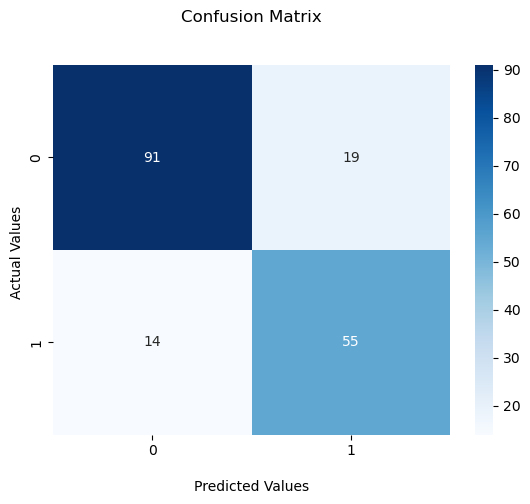

In [43]:
params = {
    'preprocessor__numeric_preprocessing__pca__n_components': [0.97, 0.985, 0.99, 0.995],
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2', None],
    'model__solver': ['sag', 'saga', 'lbfgs', 'newton-cg']
}

grid_search = GridSearchCV(model_pipeline_LogReg, 
                           params, 
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2, 
                           scoring = make_scorer(f1_score, pos_label=1)
                          )

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
model_pipeline_LogReg = grid_search.best_estimator_

metrics_df = result_summary("LogisticRegression", model_pipeline_LogReg.predict(X_test), metrics_df, y_test)

## RandomForestClassifier

#### Second Classifier that will be used is RandomForestClassifier. In the first step, a Pipeline is prepared, the purpose of which is to prepare the data for classification, so that gridSeach can also be used. Numeric Data need to be scaled  only for PCA. All previously used classes are used, missing data is filled in. OneHotEncoder is used on all categorical data. Data are not balanced so RandomForestClassifier will be run with class_weight='balanced' to cover this issue.

In [44]:
num_preparation = Pipeline(steps=[
    ('age_range', Age_Range(column='Age')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.96))
                                 ])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('filter_cabin', Filter_Cabin(column='Cabin')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_RndFor = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', RandomForestClassifier(class_weight= 'balanced'))])

#### Params are defined for GridSearch, which finds the optimal parameters for the classifier with the highest F1 Score for class "1". The results are written to DataFrame, ClassificationReport, ConfusionMatrix are displayed

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 50, 'preprocessor__numeric_preprocessing__pca__n_components': 0.96}
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



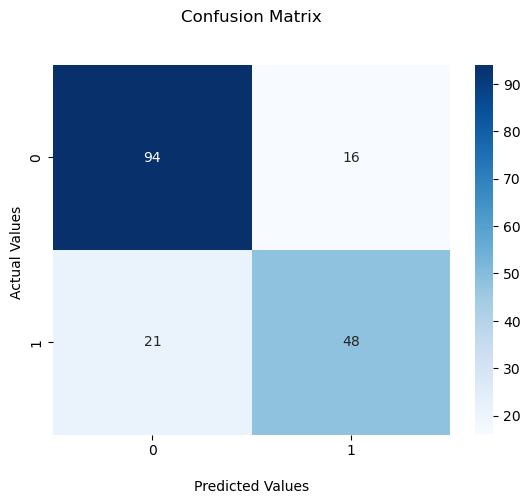

In [45]:
param_grid = {  
    'preprocessor__numeric_preprocessing__pca__n_components': [0.95, 0.96, 0.99],
    'model__n_estimators': [ 30, 50, 80],           
    'model__max_depth': [None, 10, 20],           
    'model__min_samples_split': [2, 3, 4, 7],    
    'model__min_samples_leaf': [1, 3, 4, 10]  
}

grid_search = GridSearchCV(
    estimator = model_pipeline_RndFor,
    param_grid = param_grid,
    scoring = make_scorer(f1_score, pos_label=1),
    cv=5,
    verbose = 2,
    n_jobs = -1
) 

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
model_pipeline_RFC = grid_search.best_estimator_
metrics_df = result_summary("Random Forest", model_pipeline_RFC.predict(X_test), metrics_df, y_test)

## Neural Networks

#### Pipeline is used only to prepare data for further training process. In this case for training data we use "fit_transform", test data also needs to be transformed before using them.

In [46]:
num_preparation = Pipeline(steps=[
    ('age_range', Age_Range(column='Age')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
                                 ])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('filter_cabin', Filter_Cabin(column='Cabin')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_NN = Pipeline(steps=[('preprocessor', data_preparation)])

X_train_transform = model_pipeline_NN.fit_transform(X_train)
X_test_transform = model_pipeline_NN.transform(X_test)

#### The data is not balanced, which may contribute to not optimal way in which neural networks learn

In [47]:
y_train.value_counts(normalize=True)

Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

#### To solve this issue we will use SMOTE method that will generate additional synthetic data for lower count group

In [48]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transform, y_train)
y_train_resampled.value_counts(normalize=True)

Survived
1    0.5
0    0.5
Name: proportion, dtype: float64

#### The model for the neural networks is defined and trained

In [49]:
model = Sequential([
    tf.keras.Input(shape=(X_train_resampled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.35),
    Dense(64, activation='relu'),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dropout(0.35),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['Precision', 'Recall'])

history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
22/22 - 2s - 70ms/step - Precision: 0.5135 - Recall: 0.2815 - loss: 0.6501 - val_Precision: 0.9821 - val_Recall: 0.3254 - val_loss: 0.7756
Epoch 2/50
22/22 - 0s - 4ms/step - Precision: 0.8406 - Recall: 0.4296 - loss: 0.5415 - val_Precision: 0.9815 - val_Recall: 0.6272 - val_loss: 0.7663
Epoch 3/50
22/22 - 0s - 3ms/step - Precision: 0.7778 - Recall: 0.6741 - loss: 0.4869 - val_Precision: 0.9848 - val_Recall: 0.7692 - val_loss: 0.6411
Epoch 4/50
22/22 - 0s - 3ms/step - Precision: 0.7764 - Recall: 0.7074 - loss: 0.4707 - val_Precision: 0.9774 - val_Recall: 0.7692 - val_loss: 0.6239
Epoch 5/50
22/22 - 0s - 3ms/step - Precision: 0.7584 - Recall: 0.7556 - loss: 0.4674 - val_Precision: 0.9774 - val_Recall: 0.7692 - val_loss: 0.5726
Epoch 6/50
22/22 - 0s - 3ms/step - Precision: 0.7708 - Recall: 0.7222 - loss: 0.4353 - val_Precision: 0.9846 - val_Recall: 0.7574 - val_loss: 0.6069
Epoch 7/50
22/22 - 0s - 3ms/step - Precision: 0.8067 - Recall: 0.7111 - loss: 0.4412 - val_Precision: 0.9

#### For the trained model and test data, the optimal threshold was checked to maximize the result

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       110
           1       0.72      0.84      0.77        69

    accuracy                           0.81       179
   macro avg       0.80      0.82      0.80       179
weighted avg       0.82      0.81      0.81       179



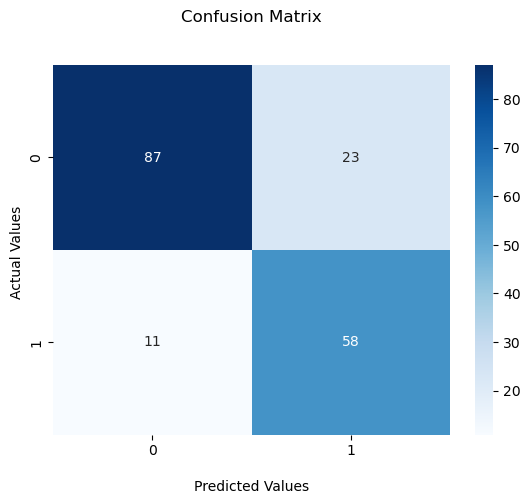

In [50]:
y_pred_prob = model.predict(X_test_transform)
max_tresh = max_treshold(y_pred_prob,  y_test)
y_pred = (y_pred_prob > max_tresh).astype(int)
metrics_df = result_summary("Neural Network", y_pred, metrics_df, y_test)

#### Display of final results

In [51]:
metrics_df.style.hide(axis="index")

Classifier,Survived,Precision,Recall,F1-score
LogisticRegression,0,0.866667,0.827273,0.846512
LogisticRegression,1,0.743243,0.797101,0.769231
Random Forest,0,0.817391,0.854545,0.835556
Random Forest,1,0.750000,0.695652,0.721805
Neural Network,0,0.887755,0.790909,0.836538
Neural Network,1,0.716049,0.840580,0.773333


### Summary
#### All received results are comperable and on similar level. 
#### LogisticRegression showed solid results, with a balance between Precision 0.743 and Recall 0.797, resulting in an F1 Score of 0.769. The result suggests that the model identifies survivors well while keeping the number of false positives relatively low.
#### The decision tree model showed a slightly higher Precision of 0.75 compared to LogisticRegression, meaning that it is slightly more likely to misclassify nonsurvivors as survivors. Recall of 0.695 and F1 Score of 0.721 are good, but do not outperform the simpler Logistic Regression model. Random Forest may be better in scenarios where more complex features and relationships are available.
#### The NN model achieved the highest Recall of 0.84, which means it is the most effective in detecting survivors. F1 Score 0.77 is very good, which suggests that Neural Network may be the best choice if we want maximum survivor detection.